# River as a shapefile (raw format)

In [1]:
import matplotlib.pyplot as plt
import geopandas as gpd

shapefile = gpd.read_file("edges.shp")
shapefile["rid"] = shapefile["rid"].astype(int)
shapefile.head()

,rid,netID,upDist,shreve,Length,addfunccol,geometry
0,1,1,1.000000,4.0,1.000000,1.00,"LINESTRING (0.00000 1.00000, 0.00000 0.00000)"
1,2,1,1.960106,1.0,0.960106,0.25,"LINESTRING (0.42592 1.86046, 0.00000 1.00000)"
2,3,1,1.980141,3.0,0.980141,0.75,"LINESTRING (0.16583 1.96601, 0.00000 1.00000)"
3,4,1,3.032648,1.0,1.052508,0.25,"LINESTRING (0.05008 3.01213, 0.16583 1.96601)"
4,5,1,3.072281,2.0,1.092141,0.50,"LINESTRING (0.75061 2.88840, 0.16583 1.96601)"


rid - unique identifier for river segment\
netID - river network ID, when dealing with multiple river outlets\
upDist - distance upstream from outlet (from the most upstream point on line)\
shreve - segment weighting based on Shreve's order\
addfunccol - additive function column, normalised shreve's order (used for weighting segments, a proxy for water volume)

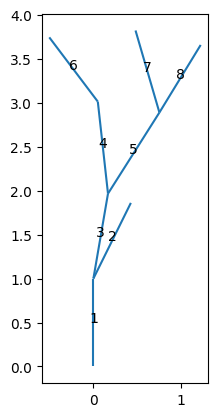

In [2]:
# edges (rid's)
ax = shapefile.plot()
shapefile.apply(
    lambda x: ax.annotate(text=x["rid"], xy=x.geometry.centroid.coords[0], ha="center"),
    axis=1,
)
plt.show()

In [3]:
# extract point information from shapely object: type(shapefile.geometry[0])
shapefile["points"] = shapefile.apply(lambda l: list(l["geometry"].coords), axis=1)
shapefile[["points_from", "points_to"]] = shapefile["points"].to_list()

# create a unique identifier for the start/end points of an edge
unique_locations = sorted(
    list(set([item for sublist in shapefile.points.to_list() for item in sublist]))
)
PID_GPT = {i: unique_locations[i] for i in range(len(unique_locations))}
GPT_PID = {v: k for k, v in PID_GPT.items()}

# map from geographic point, GPT, to unique node identifier, PID
shapefile["pid_from"] = shapefile["points_from"].apply(lambda x: GPT_PID[x])
shapefile["pid_to"] = shapefile["points_to"].apply(lambda x: GPT_PID[x])

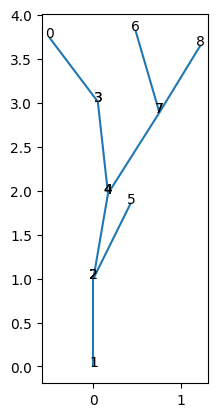

In [4]:
# node labels (pid's)
ax = shapefile.plot()
shapefile.apply(
    lambda x: ax.annotate(text=x["pid_from"], xy=x.points_from, ha="center"), axis=1
)
shapefile.apply(
    lambda x: ax.annotate(text=x["pid_to"], xy=x.points_to, ha="center"), axis=1
)
plt.show()

In [5]:
# neither of these functions are necessary, now I realise
def get_upstream_rids(row, df):
    upstream_rids = []
    up = df[df["pid_to"] == row["pid_from"]]

    while len(up) > 0:
        new_pids = list(up["pid_from"])
        upstream_rids.extend(up["rid"])
        up = df[df["pid_to"].isin(new_pids)]

    return upstream_rids


def calculate_on_left(df):
    grouped = df.groupby("pid_to")
    min_pid_from = grouped["pid_from"].transform("min")
    df["on_left"] = min_pid_from == df["pid_from"]
    return df

In [6]:
df = shapefile[
    ["rid", "upDist", "shreve", "Length", "addfunccol", "pid_from", "pid_to"]
].copy()

df["upstream_rids"] = df.apply(lambda x: get_upstream_rids(x, df), axis=1)
df = calculate_on_left(df)

## River domain representation (continuous)

#### Mapping from segment to space

In [7]:
pid = 1  # the outlet node
df.loc[df["pid_to"] == pid, ["parent_x_offset"]] = 0
df.loc[df["pid_to"] == pid, ["parent_width"]] = 1

from_pids_line_up = []
finished = False

while not finished:
    # of length either 1 or 2
    if len(df[df["pid_from"] == pid]) > 0:
        df.loc[df["pid_to"] == pid, "parent_x_offset"] = float(
            df[df["pid_from"] == pid]["x_offset"].iloc[0]
        )
        df.loc[df["pid_to"] == pid, "parent_width"] = float(
            df[df["pid_from"] == pid]["width"].iloc[0]
        )

    layer = df[df["pid_to"] == pid].copy()
    layer["pct"] = layer["addfunccol"] / layer["addfunccol"].sum()
    from_pids = layer["pid_from"]

    if len(from_pids) == 0:
        finished = len(from_pids_line_up) == 0
        if not finished:
            pid = from_pids_line_up.pop(0)
        continue

    # add percentage share of addfunccol at each branching confluence
    df.loc[df["pid_from"].isin(from_pids), ["width"]] = (
        layer["parent_width"] * layer["pct"]
    )

    # for the branch on left, then right
    df.loc[df["pid_from"] == min(from_pids), ["x_offset"]] = layer["parent_x_offset"]

    if len(from_pids) == 2:
        df.loc[df["pid_from"] == max(from_pids), ["x_offset"]] = float(
            layer["parent_x_offset"].iloc[0]
        ) + float(df.loc[df["pid_from"] == min(from_pids), ["width"]].squeeze())

    # get next pid's
    from_pids_line_up.extend(list(from_pids))
    finished = len(from_pids_line_up) == 0
    pid = from_pids_line_up.pop(0)

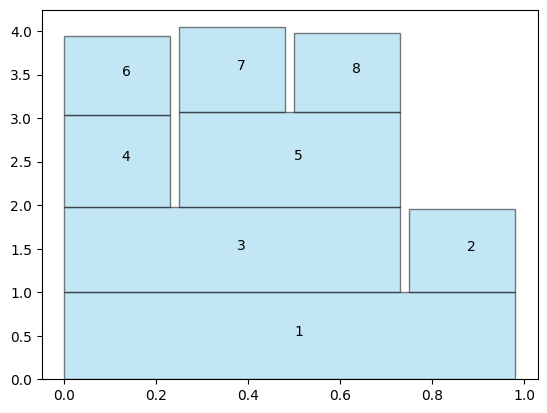

In [22]:
# plot bar
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.bar(
        row["x_offset"],
        height=row["Length"],
        bottom=row["upDist"] - row["Length"],
        width=row["addfunccol"] - 0.02,  # epsilon
        align="edge",
        color="skyblue",
        alpha=0.5,
        edgecolor="black",
    )
    ax.annotate(
        row["rid"],
        xy=(
            row["x_offset"] + 0.5 * row["addfunccol"],
            row["upDist"] - 0.5 * row["Length"],
        ),
    )

plt.show()

##### River domain representation (as a shapely.Polygon object)

In [38]:
epsilon = 0.02
df["box_coord"] = [list() for i in range(len(df))]

for i, row in df.iterrows():
    x_left = row["x_offset"]
    x_right = row["x_offset"] + row["addfunccol"] - epsilon
    y_top = row["upDist"]
    y_bottom = row["upDist"] - row["Length"]

    df.loc[i, "box_coord"].extend(
        [
            (x_left, y_bottom),
            (x_left, y_top),
            (x_right, y_top),
            (x_right, y_bottom),
        ]
    )  # bottom-left, top-left, top-right, bottom-right (clockwise)

In [42]:
from itertools import groupby


def group_by_x(tuples):
    sorted_tuples = sorted(tuples, key=lambda point: point[0])
    groups = []

    for _, group in groupby(sorted_tuples, key=lambda point: point[0]):
        groups.append(list(group))

    return groups

In [50]:
all_points = sorted([item for sublist in df["box_coord"].values for item in sublist])
grouped_x = group_by_x(all_points)

new_list = []
for i, l in enumerate(grouped_x):
    if i % 2 == 0:
        new_list.append(l[0])
        new_list.append(l[-1])
    else:
        new_list.append(l[-1])
        new_list.append(l[0])

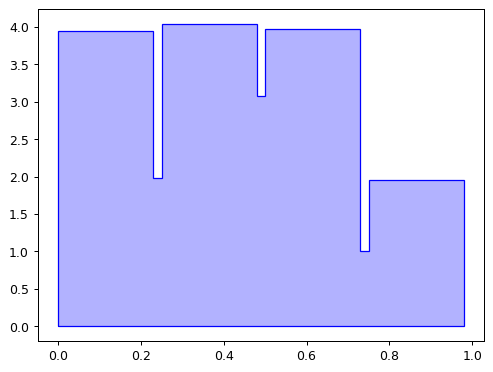

In [58]:
# create high-coverage continous domain representation
from shapely.geometry import Polygon
from shapely.plotting import plot_polygon, plot_points

fig = plt.figure(1, dpi=90)
ax = fig.add_subplot()
int = new_list + [new_list[0]]
polygon = Polygon(int)

plot_polygon(polygon, ax=ax, add_points=False, color="b")
plt.show()

In [59]:
# any shapely helper functions??? inside shape? distance?

# Model

Linear regression models that describe spatio-temporal dependence are generally formulated as:

$\bf y = \bf X \boldsymbol \beta + \bf v + \boldsymbol \epsilon$

where $\bf y$ is a stacked response vector of size $n \times 1$, with $n = S \times T$ (for $S$ spatial locations and $T$ timepoints), $\bf X$ is a $n \times p$ design matrix of $p$ covariates, $\boldsymbol \beta$ is a $p \times 1$ vector or regression coefficients, and $\bf v$ is a vector of spatio-temporal autocorrelated random effects.


\
Two main approaches are generally found to model spatio-temporal autocorrelation: 

(1) full covariance or descriptive models in which the space-time covariance function is constructed (i.e. Separable space-time VAR(1) model), and \
(2) dynamical model that involves the evolution of a spatial process (i.e. Vector autoregression spatial model)

In the second approach we just need to construct the spatial covariance matrix. Temporal dependence is incorporated in the error terms using a vector autoregression VAR(1). Edgar's paper showed that both approaches are equivalent, and the second approach is more computationally efficient.


#### Bayesian hierarchical model

$ p(\bf y_t | \bf y_{t-1}, \boldsymbol \theta, \bf X_t, \bf X_{t-1}, \boldsymbol \Phi_1, \Sigma) = \mathcal{N}(\boldsymbol \mu_t, \Sigma + \sigma_0^2 \bf I)$

$\boldsymbol \mu_t = \bf X_t \boldsymbol \beta + \boldsymbol \Phi_1(\bf y_{t-1} - \bf X_{t-1} \boldsymbol \beta)$

where

$\boldsymbol \Sigma = Cov(v_i)\ \forall i = 1,...,T$ is the $S \times S$ spatial covariance matrix, e.g., formulated by the exponential function with matrix entries of the form

$\boldsymbol \Sigma_{ij} := C(h_{ij} | \boldsymbol \theta) = \sigma_1^2 \exp(-h_{ij}/\alpha), \ \alpha > 0,\ h_{ij}$ is the stream distance between locations $s_i$ and $s_j$. Denote spatial covariance parameters by $\boldsymbol \theta = (\sigma_0^2,\sigma_1^2,\alpha)$.


$\boldsymbol \Phi_1$ is the $S \times S$ transition matrix determining the amount of temporal autocorrelation, e.g., in the simplest case, assuming the same temporal autocorrelation for all spatial locations, the diagonal elements of $\boldsymbol \Phi$ are all equal to $\phi$ and all the off-diagonal ones are set to zero,


$\boldsymbol \Phi_1 = 
\begin{bmatrix}
\phi & 0 & 0 & \cdots & 0 \\
0 & \phi & 0 & \cdots & 0 \\
0 & 0 & \phi & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & \phi \\
\end{bmatrix}
$


##### Hyper priors

$\beta_1,...,\beta_p \sim \mathcal(0,10)$   # prior on the regression coefficients

$\sigma_0 \sim \text{Uniform}(0, 1) $ # prior on the nugget effect

$\sigma_1 \sim \text{Uniform}(0, 10) $ # prior partial sill parameters

$\alpha \sim \text{Uniform}(0, 16) $ # prior on spatial range parameters

$\phi \sim \text{Uniform}(-1,1) $ # prior on the autoregressive parameters, elements of $\boldsymbol \Phi_1$

See: https://www.fs.usda.gov/rm/pubs_journals/2022/rmrs_2022_santos_fernandes_e001.pdf


# Generator

In [ ]:
# TODO: create generator onject on domain;
# - add points, calculate distance

## River as graph (NetworkX)

C:\Users\n10907700\AppData\Local\Temp\ipykernel_23724\1569939559.py:11: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(


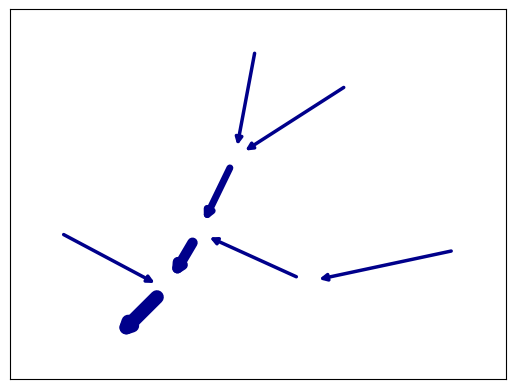

In [15]:
import networkx as nx

# encode as networkx object and plot
G = nx.DiGraph()
G.add_weighted_edges_from(
    list(zip(shapefile.pid_from, shapefile.pid_to, shapefile.addfunccol * 10))
)
# adding edges in the form: G.add_weighted_edges_from([(1, 2, 0.5), (3, 1, 1.75)])
pos = nx.spring_layout(G)
widths = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=widths.keys(),
    width=list(widths.values()),
    edge_color="darkblue",
    alpha=1,
)
plt.show()
# nodelist = G.nodes()
# nx.draw_networkx_nodes(G,pos,
#                        nodelist=nodelist,
#                        node_size=1500,
#                        node_color='black',
#                        alpha=0.7)
# nx.draw_networkx_labels(G, pos=pos,
#                         labels=dict(zip(nodelist,nodelist)),
#                         font_color='white')